# Árboles de decisión y Random Forest como modelos de regresión

Como muchos algoritmos de machine-learning, los árboles de decisión pueden utilizarse tanto para problemas de clasificación como de regresión. Cuando implementamos los árboles para regresión, cada vez que se cree una nueva rama, el valor predicho para la variable dependiente será el promedio de las instancias que caen dentro de la misma. Así, el criterio para separar será aquel que minimice el error entre los valores reales y el valor predicho.

### Carga de librerías


In [ ]:
# Librerias generales y montaje del drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


En esta notebook vamos a utilizar datos georeferenciados. Para inspeccionar cómo el árbol los usa, vamos a necesitar la siguiente librería, muy similar a *pandas*, llamada (qué otro nombre podría llevar) *geopandas*, que nos sirve para trabajar con este tipo de datos.

**Observación**: vamos a tener una clase específica de datos georeferenciados!

In [ ]:
# Esta librería no viene por default y hay que instalarla con "pip"
# Por lo tanto al cargarla es muy probable que se vean varias leyendas del proceso de instalación
!pip install geopandas
import geopandas as gpd

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 38.4 MB/s 
     |████████████████████████████████| 16.7 MB 416 kB/s 


Módulos de scikit-learn para árboles de regresión y métricas para evaluar nuestro modelo:

In [ ]:
# Modulos específicos para árboles de decisión
from sklearn.tree import DecisionTreeRegressor # Arboles de decisión para regresión
from sklearn.tree import plot_tree # Función para visualizar el árbol

from sklearn.ensemble import RandomForestRegressor # Random forests para decisión

# Módulos utiles para evaluar el modelo
from sklearn.model_selection import train_test_split # Para separar en train y test
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

## Base de datos

Los datos con los que vamos a trabajar son precios de venta de departamentos de la ciudad de Buenos Aires del año 2016. La idea es utilizar árboles de decisión para estimar el precio del inmueble en base a la cantidad de $m^2$, antigüedad, cantidad de ambientes y de baños, y ubicación en términos de la latitud y longitud.  

Los datos fueron obtenidos de la paǵina del [portal del datos del GCBA](https://data.buenosaires.gob.ar/dataset/departamentos-venta) y fueron levemente curados al, por ejemplo, eliminar datos de departamentos en pozo, seleccionar algunas pocas columnas de interés, descartar instancias con datos faltantes, entre otras cosas. Dado que es una notebook sobre árboles, que mejor que un problema de bienes raíces...

In [ ]:
# Path de nuestro dataset
filename = '/content/drive/My Drive/LaboDatos2022/Precios_Departamentos_2016.csv'

In [ ]:
# Carga del dataset
df = pd.read_csv(filename)

print('Dimensión del dataset: {}'.format(df.shape))

# Inspección de los primeros datos
df.head()

Dimensión del dataset: (2232, 8)


,M2,AMBIENTES,ANTIGUEDAD,BAÑOS,LATITUD,LONGITUD,COMUNA,DOLARES
0,81,3,4,1,-34.581078,-58.449433,COMUNA 13,225000
1,69,3,20,1,-34.623129,-58.439338,COMUNA 06,140000
2,75,3,20,1,-34.604972,-58.421278,COMUNA 05,154000
3,42,2,40,1,-34.604725,-58.399524,COMUNA 03,75000
4,90,3,1,1,-34.623390,-58.504401,COMUNA 10,149900


### Visualización de los datos

Veamos un poquito dónde se ubican los inmuebles. Para ver dónde están distribuidos en la superficie de la ciudad de Buenos Aires vamos a usar los datos de los límites de ésta, que vamos a manipular con la librería de geopandas.

**Observación**: recuerden, esto no es lo importante de esta notebook! Más sobre datos georeferenciados en futuras clases!

Text(0, 0.5, 'LATITUD')

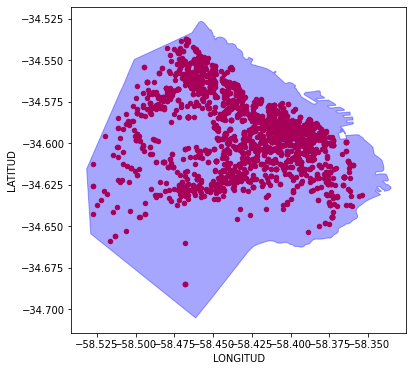

In [ ]:
# Datos de los límites de diferentes municipios del país levantados con geopandas
data_muni = gpd.read_file('/content/drive/My Drive/LaboDatos2021/ign_municipio.shp')

# Creamos la figura con matplotlib
fig, ax = plt.subplots(figsize = (6, 6))

# Función para plotear la superficie de CABA (el índice es simplemente el correspondiente a la ciudad de Buenos Aires)
# No enroscarse con esto, ya veremos cómo manejar este tipo de datos
ax.fill(*data_muni.iloc[704]['geometry'].exterior.xy, color = 'b', alpha = 0.35)

# Hacemos un scatter plot para ubicar los inmuebles
df.plot(ax = ax, x = 'LONGITUD', y = 'LATITUD', kind = 'scatter', color = 'r')

# Labels de los ejes
ax.set_xlabel('LONGITUD')
ax.set_ylabel('LATITUD')

Siempre visualizar un poco los datos ayuda a entender las limitaciones. En este caso parecen estar poco representados inmuebles en el sur de la ciudad. No vamos a hacer un trato especial, pero es bueno tenerlo presente.

**Tarea para el hogar**: ver cómo se distribuyen las demás variables.

### Variable a predecir

El objetivo de está notebook es predecir el precio de los inmuebles (columna DOLARES en el dataframe). Dado que esta variable abarca varios ordenes de magnitud, vamos a trabajar con el logaritmo en base 10 de la misma. Para ello creamos una nueva columna en el dataframe, calculada de la siguiente manera:

In [ ]:
# Logaritmo en base 10 del precio en dolares del inmueble
df['log10_DOLARES'] = np.log10(df['DOLARES'])

# Inspección de los primeros datos
df.head()

,M2,AMBIENTES,ANTIGUEDAD,BAÑOS,LATITUD,LONGITUD,COMUNA,DOLARES,log10_DOLARES
0,81,3,4,1,-34.581078,-58.449433,COMUNA 13,225000,5.352183
1,69,3,20,1,-34.623129,-58.439338,COMUNA 06,140000,5.146128
2,75,3,20,1,-34.604972,-58.421278,COMUNA 05,154000,5.187521
3,42,2,40,1,-34.604725,-58.399524,COMUNA 03,75000,4.875061
4,90,3,1,1,-34.623390,-58.504401,COMUNA 10,149900,5.175802


## Construcción del módelo: árbol de decisión

Empecemos trabajando con un único árbol. Al final de la notebook exploraremos un *ensamble* de árboles como es el algoritmo de *Random Forest*.

### Preprocesamiento: selección de features y separación en entrenamiento y testeo

In [ ]:
# Lista de features que vamos a considerar
features = ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'LATITUD', 'LONGITUD']

# Variable a predecir
target = 'log10_DOLARES'

# Construcción de la matriz de features
X = df[features].to_numpy()

# Construcción del vector a predecir
y = df[target].to_numpy()

print('Dimensión de la matriz de features: {}'.format(X.shape))
print('Dimensión del vector a predecir: {}'.format(y.shape))
print('Vector a predecir: {}'.format(y))

Dimensión de la matriz de features: (2232, 6)
Dimensión del vector a predecir: (2232,)
Vector a predecir: [5.35218252 5.14612804 5.18752072 ... 5.71600334 5.12057393 5.25285303]


Separamos nuestros datos en entrenamiento y testeo. Vamos a dejar un 10% de los datos para testear y vamos a trabajar con los otros.

In [ ]:
# Solo por esta vez para a fijar la semilla de numeros aleatorios
# para que se separe siempre igual cada vez que corramos esta notebook
random_seed = 123475

# Creacion de las matrices de entrenamiento y testeo. Aca fijamos la semilla para que siempre separe igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = random_seed)

print('Dimensión de la matriz de features para entrenamiento: {}'.format(X_train.shape))
print('Dimensión de la matriz de features para testeo: {}'.format(X_test.shape))

Dimensión de la matriz de features para entrenamiento: (2008, 6)
Dimensión de la matriz de features para testeo: (224, 6)


### [Creación y ajuste del modelo](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decision%20tree%20regressor)

Aquí creamos efectivamente el árbol de regresión. Vamos a comenzar creando un árbol de profundidad igual a 3 (es decir, que tiene $2^3 = 8$ hojas) y luego vamos a ir jugando con los distintos parámetros.

Como todos los modelos en *scikit-learn* hay una línea que se refiere a la construción del modelo, otra al entrenamiento, y luego podemos predecir o ver la performance del modelo.

In [ ]:
# Construcción del árbol de decisión de profundidad 3
dtr = DecisionTreeRegressor(max_depth = 3, random_state = random_seed)

# Observación: todos los algoritmos tienen una componente aleatoria:
# solo por esta vez permitanme fijar la semilla de numeros aleatorios para que los resultados sean reproducibles.

In [ ]:
# Entrenamiento del modelo con el método fit
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=123475)

In [ ]:
# Score del modelo en los datos de entrenamiento (siempre esperamos que aquí sea alto)
score_in_train = dtr.score(X_train, y_train)

print('Score en el set de entrenamiento: {}'.format(score_in_train))

Score en el set de entrenamiento: 0.7878635222988184


In [ ]:
# Score del modelo en los datos de testeo
# (acá puede fluctuar pero en general es bajo respecto a los datos de entrenamiento)
score_in_test = dtr.score(X_test, y_test)

print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de testeo: 0.6958297322898355


#### Visualización del árbol

Aquí vamos a visualizar el árbol. Para árboles chicos está bueno, para árboles grandes hay que ajustar bien los tamaños de las figuras.

[Text(0.5, 0.875, 'M2 <= 97.5\nsquared_error = 0.082\nsamples = 2008\nvalue = 5.203'),
 Text(0.25, 0.625, 'M2 <= 50.5\nsquared_error = 0.036\nsamples = 1565\nvalue = 5.091'),
 Text(0.125, 0.375, 'M2 <= 41.5\nsquared_error = 0.018\nsamples = 719\nvalue = 4.958'),
 Text(0.0625, 0.125, 'squared_error = 0.011\nsamples = 425\nvalue = 4.898'),
 Text(0.1875, 0.125, 'squared_error = 0.015\nsamples = 294\nvalue = 5.046'),
 Text(0.375, 0.375, 'LATITUD <= -34.599\nsquared_error = 0.023\nsamples = 846\nvalue = 5.203'),
 Text(0.3125, 0.125, 'squared_error = 0.014\nsamples = 344\nvalue = 5.118'),
 Text(0.4375, 0.125, 'squared_error = 0.021\nsamples = 502\nvalue = 5.262'),
 Text(0.75, 0.625, 'M2 <= 143.0\nsquared_error = 0.047\nsamples = 443\nvalue = 5.598'),
 Text(0.625, 0.375, 'M2 <= 111.5\nsquared_error = 0.03\nsamples = 230\nvalue = 5.478'),
 Text(0.5625, 0.125, 'squared_error = 0.017\nsamples = 87\nvalue = 5.38'),
 Text(0.6875, 0.125, 'squared_error = 0.028\nsamples = 143\nvalue = 5.538'),
 Text

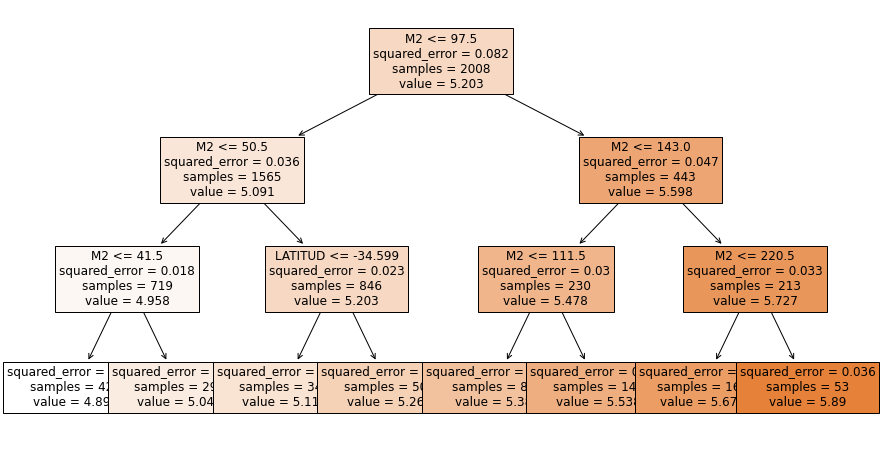

In [ ]:
# Creamos la figura donde plotear el árbol con matplotlib
fig, ax = plt.subplots(figsize = (15, 8))

# Llamamos a la función "plot_tree" que importamos de sklearn.tree más arriba.
# Le pasamos como argumento el modelo que creamos y el nombre de los features.
# "fontsize" y "filled" son solo ajustes de la visualización
# y le decimos que plotee el arbol en la figura que creamos
plot_tree(dtr, feature_names=features, fontsize = 12, filled = True, ax = ax)

**¿Cómo interpretamos este gráfico?**

- El árbol se lee de arriba hacia abajo.
- Cada nodo representa una pregunta que se responde con **verdadero** y **falso**: si es verdadero tomamos la rama de la izquierda; si es falso, la de la derecha.
- La pregunta está marcada por la primer línea en cada bloque.

Comencemos leyendo paso por paso:

- Primer nodo (raíz del árbol), la pregunta es: ¿el departamento tiene $97.5 m^2$ o menos?

Si es **sí** sigo la rama de la izquierda; si es **no**, voy a la derecha.

Los bloques nos dan más aún información:

- *samples*: es la cantidad de instancias que cumplen el critero indicado. Partimos de 2008 instancias de entrenamiento y estas se separaron en dos grupos: 1565 que cumplen el primer criterio (la de los $97.5m^2$) y 443 que no lo cumplen.
- *value*: es el valor promedio de la variable a predecir. Recordemos que esto el log10 del precio del inmueble. Así, en promedio, los departamentos con menos de $97.5m^2$ tiene un precio de $10^{5.091} \sim 123310$ dólares, mientras que los que tienen más tienen un precio de $10^{5.598} \sim 396278$ dólares.
- *mse*: es el error medio, que esperamos se vaya haciendo chico para grupos más específicos.

En las **hojas del árbol** (los bloques de la base) podemos ver qué se predice para cada instancia luego de contestar las 3 preguntas que nos plantea el árbol. Por ejemplo, si tenemos un departamento cuya superficie es menor a $97.5$, que es menor a $50.5$ y que es menor a $41.5 m^2$ (es decir, siguiendo siempre la rama que está más a la izquierda) le vamos a asignar un precio de $10^{4.898} \sim 79068$ dólares.

En este ejemplo, una variable que predice muy bien el precio son los metros cuadrados. Sin embargo, para departamentos entre $50.5$ y $97.5 m^2$, aparece la variable **latitud**. Veamos dónde se ubica este corte en el mapa:

Text(0.5, 0, 'LONGITUD')

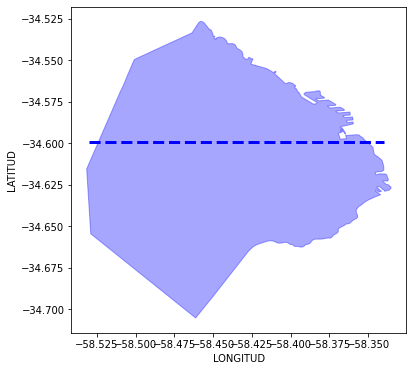

In [ ]:
# Creamos la figura con matplotlib
fig, ax = plt.subplots(figsize = (6, 6))

# Función para plotear la superficie de CABA (el índice es simplemente el correspondiente a la ciudad de Buenos Aires)
# No enroscarse con esto, ya veremos cómo manejar este tipo de datos
ax.fill(*data_muni.iloc[704]['geometry'].exterior.xy, color = 'b', alpha = 0.35)

# Línea horizontal para ver la latidud de corte (pueden agregar tantas lineas como quieran)
ax.hlines(y = -34.599, xmin = -58.53, xmax = -58.34, color = 'b', linestyle = '--', linewidth = 3)

# Con lo siguiente pueden poner líneas verticales para graficar longitudes
#ax.vlines(x = -58.365, ymin = -34.70, ymax = -34.53, color = 'r', linestyle = '--', linewidth = 3)

ax.set_ylabel('LATITUD')
ax.set_xlabel('LONGITUD')

Lo que vemos es que el árbol ya en las primeras bifurcaciones detecta que un buen indicador del precio de los inmuebles es si se ubica más al norte. Si miramos el gráfico del árbol vemos que para departamentos de más de $50.5 m^2$ el precio es más alto si el mismo se ubica por encima de la latitud indicada (en promedio, $10^{5.262} \sim 182810$ dólares para los departamentos del norte y $10^{5.118} \sim 131220$ dólares para los departamentos del sur).

### Overfitting, variación de parámetros y regularización

Uno de los problemas que tienen los árboles de decisión es que los **árboles muy profundos tienden a hacer overfitting**, dado que terminan describiendo exactamente los datos de entrenamiento. Eso lo podemos ver en las siguientes líneas de código:


In [ ]:
# Construcción del árbol de decisión con la máxima profundidad
dtr = DecisionTreeRegressor(max_depth = None)

# Entrenamiento del modelo
dtr.fit(X_train, y_train)

# Score del modelo en el conjunto de entrenamiento
score_in_train = dtr.score(X_train, y_train)

# Score del modelo en el conjunto de testeo
score_in_test = dtr.score(X_test, y_test)

print('Score en el set de entrenamiento: {}'.format(score_in_train))
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de entrenamiento: 0.9999104710391422
Score en el set de testeo: 0.8699262640164167


Mientras que el score en el set de entrenamiento es prácticamente perfecto, en el de testeo es en general bastante más bajo. Eso es un claro indicio de *overfitting*. Para evitar overfitting podemos variar la profundidad del árbol, como hicimos antes al usar un árbol más chico. Otras opciones es fijar el número de hojas, hacer crecer el árbol de forma tal de que siempre haya un mínimo de instancias, o bien agregarle un término de regularización.

#### Número fijo de hojas

Podemos construir árboles con una cantidad fija de hojas. Esto podría ser útil, por ejemplo, si quisieramos crear una cantidad fija de precios para diferentes perfiles de compradores de un producto.

[Text(0.5909090909090909, 0.875, 'M2 <= 97.5\nsquared_error = 0.082\nsamples = 2008\nvalue = 5.203'),
 Text(0.36363636363636365, 0.625, 'M2 <= 50.5\nsquared_error = 0.036\nsamples = 1565\nvalue = 5.091'),
 Text(0.18181818181818182, 0.375, 'M2 <= 41.5\nsquared_error = 0.018\nsamples = 719\nvalue = 4.958'),
 Text(0.09090909090909091, 0.125, 'squared_error = 0.011\nsamples = 425\nvalue = 4.898'),
 Text(0.2727272727272727, 0.125, 'squared_error = 0.015\nsamples = 294\nvalue = 5.046'),
 Text(0.5454545454545454, 0.375, 'LATITUD <= -34.599\nsquared_error = 0.023\nsamples = 846\nvalue = 5.203'),
 Text(0.45454545454545453, 0.125, 'squared_error = 0.014\nsamples = 344\nvalue = 5.118'),
 Text(0.6363636363636364, 0.125, 'squared_error = 0.021\nsamples = 502\nvalue = 5.262'),
 Text(0.8181818181818182, 0.625, 'M2 <= 143.0\nsquared_error = 0.047\nsamples = 443\nvalue = 5.598'),
 Text(0.7272727272727273, 0.375, 'squared_error = 0.03\nsamples = 230\nvalue = 5.478'),
 Text(0.9090909090909091, 0.375, 'sq

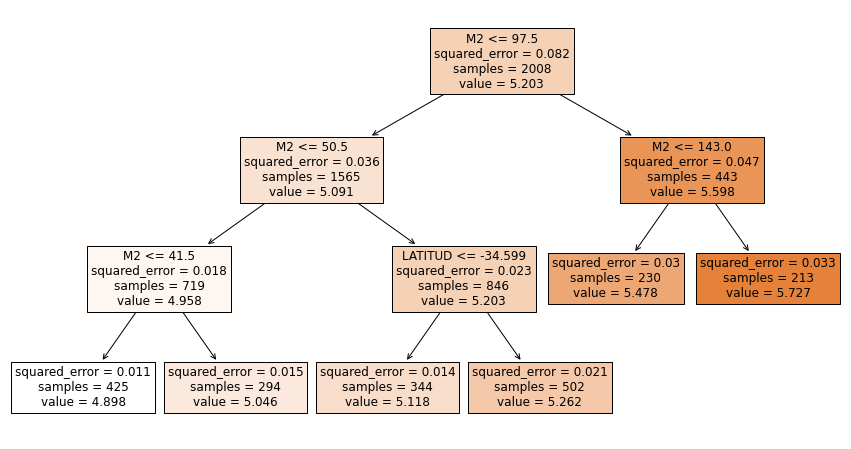

In [ ]:
# Creación del árbol con 6 hojas
dtr = DecisionTreeRegressor(max_leaf_nodes = 6)

# Entrenamiento
dtr.fit(X_train, y_train)

# Creamos la figura donde plotear el árbol con matplotlib
fig, ax = plt.subplots(figsize = (15, 8))

# Llamamos a la función "plot_tree" que importamos de sklearn.tree más arriba.
# Le pasamos como argumento el modelo que creamos y el nombre de los features.
# "fontsize" y "filled" son solo ajustes de la visualización
# y le decimos que plotee el arbol en la figura que creamos
plot_tree(dtr, feature_names=features, fontsize = 12, filled = True, ax = ax)

#### Número mínimo de instancias en cada hoja

Podemos construir árboles con una cantidad mínima de instancias en cada hoja. Esto podría ser útil si queremos que los valores promedios sean más robustos.

[Text(0.5555555555555556, 0.9, 'M2 <= 97.5\nsquared_error = 0.082\nsamples = 2008\nvalue = 5.203'),
 Text(0.4444444444444444, 0.7, 'M2 <= 50.5\nsquared_error = 0.036\nsamples = 1565\nvalue = 5.091'),
 Text(0.2222222222222222, 0.5, 'M2 <= 41.5\nsquared_error = 0.018\nsamples = 719\nvalue = 4.958'),
 Text(0.1111111111111111, 0.3, 'squared_error = 0.011\nsamples = 425\nvalue = 4.898'),
 Text(0.3333333333333333, 0.3, 'squared_error = 0.015\nsamples = 294\nvalue = 5.046'),
 Text(0.6666666666666666, 0.5, 'LATITUD <= -34.599\nsquared_error = 0.023\nsamples = 846\nvalue = 5.203'),
 Text(0.5555555555555556, 0.3, 'squared_error = 0.014\nsamples = 344\nvalue = 5.118'),
 Text(0.7777777777777778, 0.3, 'M2 <= 70.5\nsquared_error = 0.021\nsamples = 502\nvalue = 5.262'),
 Text(0.6666666666666666, 0.1, 'squared_error = 0.02\nsamples = 252\nvalue = 5.2'),
 Text(0.8888888888888888, 0.1, 'squared_error = 0.014\nsamples = 250\nvalue = 5.324'),
 Text(0.6666666666666666, 0.7, 'squared_error = 0.047\nsamples 

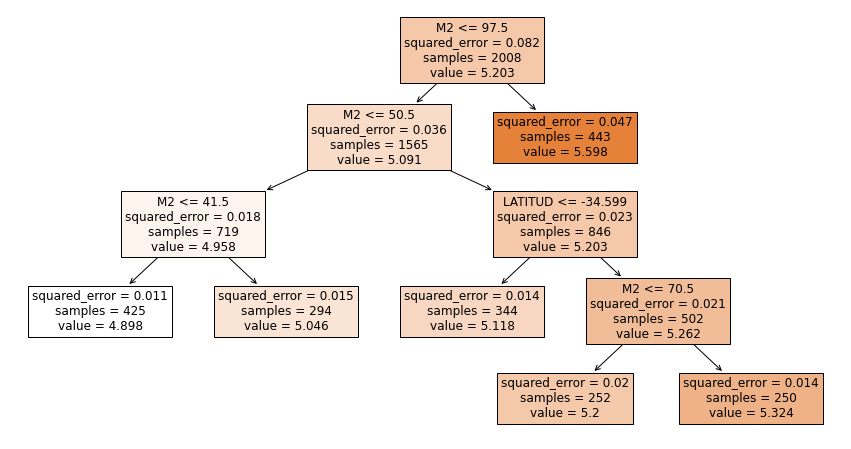

In [ ]:
# Creación del árbol con al menos 250 instancias dentro de cada hoja
dtr = DecisionTreeRegressor(min_samples_leaf = 250)

# Entrenamiento
dtr.fit(X_train, y_train)

# Creamos la figura donde plotear el árbol con matplotlib
fig, ax = plt.subplots(figsize = (15, 8))

# Llamamos a la función "plot_tree" que importamos de sklearn.tree más arriba.
# Le pasamos como argumento el modelo que creamos y el nombre de los features.
# "fontsize" y "filled" son solo ajustes de la visualización
# y le decimos que plotee el arbol en la figura que creamos
plot_tree(dtr, feature_names=features, fontsize = 12, filled = True, ax = ax)

#### Regularización: pruning

En vez de variar los argumentos anteriores, una forma análoga es agregar un término de regularización al momento de minimizar el error promedio en la predicción. Es decir, al construir un árbol se suele minimizar una expresión del estilo:
$$\sum_{i} (y_i - \hat{y}_i)^2 + \alpha |T|$$
donde el primer término es el cuadrado de los residuos (diferencia entre los valores reales y los valores predichos) y el segundo término es el de regularización. $|T|$ es la cantidad de hojas (nodos terminales) que tiene nuestro árbol (ver capítulo 8 de *Introduction to Statistical Learning*).

Un valor de $\alpha$ distinto de cero penaliza árboles profundos. Esta regularización es similar a *lasso* en el contexto de regresión lineal. El efecto que tiene agregar regularización es el de "podar" el árbol (*pruning* en inglés).



[Text(0.6, 0.8333333333333334, 'M2 <= 97.5\nsquared_error = 0.082\nsamples = 2008\nvalue = 5.203'),
 Text(0.4, 0.5, 'M2 <= 50.5\nsquared_error = 0.036\nsamples = 1565\nvalue = 5.091'),
 Text(0.2, 0.16666666666666666, 'squared_error = 0.018\nsamples = 719\nvalue = 4.958'),
 Text(0.6, 0.16666666666666666, 'squared_error = 0.023\nsamples = 846\nvalue = 5.203'),
 Text(0.8, 0.5, 'squared_error = 0.047\nsamples = 443\nvalue = 5.598')]

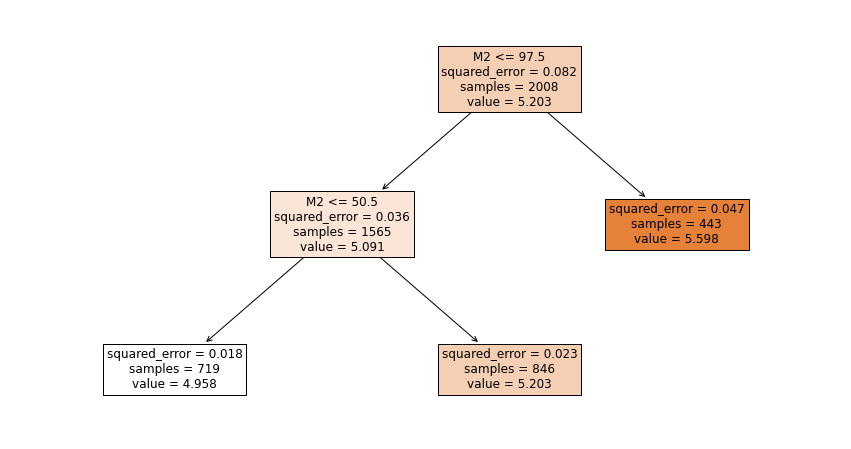

In [ ]:
# Creación del árbol con un término de regulación con constante 0.01
dtr = DecisionTreeRegressor(ccp_alpha = 0.01)

# Entrenamiento
dtr.fit(X_train, y_train)

# Creamos la figura donde plotear el árbol con matplotlib
fig, ax = plt.subplots(figsize = (15, 8))

# Llamamos a la función "plot_tree" que importamos de sklearn.tree más arriba.
# Le pasamos como argumento el modelo que creamos y el nombre de los features.
# "fontsize" y "filled" son solo ajustes de la visualización
# y le decimos que plotee el arbol en la figura que creamos
plot_tree(dtr, feature_names=features, fontsize = 12, filled = True, ax = ax)

¿Cómo elegimos $\alpha$? Podemos hacer cross-validation:

In [ ]:
# Tomamos un valor de alpha entre 10^-10 y 1. Usamos un barrido logaritmico.
for alpha in np.logspace(-10, 0, 11):

    # Creamos el modelo para un dado valor de alpha
    dtr = DecisionTreeRegressor(ccp_alpha = alpha)

    # Calculamos los scores al hacer cross-validation con 5 folds
    scores = cross_val_score(dtr, X_train, y_train, cv = 5)

    # Imprimimos el valor de alpha y el score medio
    print('Valor de alpha {} - Score medio = {}'.format(alpha, scores.mean()))

Valor de alpha 1e-10 - Score medio = 0.8640427262533409
Valor de alpha 1e-09 - Score medio = 0.8595041490416161
Valor de alpha 1e-08 - Score medio = 0.856501348453382
Valor de alpha 1e-07 - Score medio = 0.8544586537911425
Valor de alpha 1e-06 - Score medio = 0.8636116875395015
Valor de alpha 1e-05 - Score medio = 0.8655077071350366
Valor de alpha 0.0001 - Score medio = 0.8430081967225277
Valor de alpha 0.001 - Score medio = 0.761147049611913
Valor de alpha 0.01 - Score medio = 0.6007217143218287
Valor de alpha 0.1 - Score medio = -0.0031446945453883933
Valor de alpha 1.0 - Score medio = -0.0031446945453883933


Más o menos vemos que con un valor de $\alpha = 10^{-5}$  tenemos un buen score y sabemos que nos previene de hacer overfitting. Vemos a qué profundidad de árbol corresponde y qué tan bien le va en el set de testeo:

In [ ]:
# Creación del modelo con regularización óptima
dtr = DecisionTreeRegressor(ccp_alpha = 10**-5)

# Entrenamiento
dtr.fit(X_train, y_train)

# Profundidad del árbol al entrenarlo regularizado
depth = dtr.get_depth() # Con este método vemos la profundidad
print('Profundidad del arbol = {}'.format(depth))

# Score en el set de testeo
score_in_test = dtr.score(X_test, y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Profundidad del arbol = 15
Score en el set de testeo: 0.8774662390809131


## [Random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest)

Una mejora sustancial a los árboles de decisión es el algoritmo de random forests. Este algoritmo es un **ensamble de árboles de decisión**, es decir, construye muchos árboles de decisión arrancando con features elegidos al azar y la predición final la hace promediando los valores predichos por cada árbol.

La ventaja que tiene este algoritmo es que aumentar el número de árboles que intervienen en la predicción no necesariamente lleva al overfitting, por lo que los hiperparámetros que variamos son los de los árboles individuales (profundidad, regularización, etc). La sintaxis de scikit-learn es idéntica a los árboles individuales.

In [ ]:
# Constuimos el modelo de Random Forest con 100 estimadores
# Por default, cada árbol individual es entrenado hasta máxima profundidad
rfr = RandomForestRegressor(n_estimators=100)

In [ ]:
# Entrenamiento del modelo
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Score en el set de testeo
score_in_test = rfr.score(X_test, y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de testeo: 0.9082199391143136


La desventaja que tiene Random Forest por sobre los árboles de decisión es que son díficiles de interpretar. Ya no es tan cómo se predice un dado valor. Sin embargo, podemos inspeccionar un poco la importancia de cada feature con el siguiente atributo del modelo:

In [ ]:
# Este atributo tiene una medida de la importancia de cada feature
feature_importance = rfr.feature_importances_

print('Features: {}'.format(features))
print('Importancia = {}'.format(feature_importance))

Features: ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'LATITUD', 'LONGITUD']
Importancia = [0.81663241 0.01077439 0.03617011 0.00738428 0.08015435 0.04888446]


La importancia de cada feature está medida con qué tanto reduce el error al usarlo como criterio de separación en cada árbol. Lo que vemos para este ejemplo es que el feature más informativo es el de los $m^2$ de cada departamento, mientras que los dos features siguientes en orden de importancia son a latitud y longitud, es decir, la ubicación del inmueble.

Veamos alguna predicción. Acuerdense que la variable que predecimos es el $log10$ del precio (y que para clasificar una única instancia usamos el método .reshape(1, -1)):

In [ ]:
# Características
print('Features = {}'.format(features))
print('{}'.format(X_test[0]))

# Valor predicho
p = rfr.predict(X_test[0].reshape(1, -1))

#Precios
print('Valor predicho = {}'.format(10**p))
print('Valor esperado = {}'.format(10**y_test[0]))

Features = ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'LATITUD', 'LONGITUD']
[ 70.           3.         110.           1.         -34.61150487
 -58.39326147]
Valor predicho = [120693.69131913]
Valor esperado = 152999.99999999985


## Cosas para llevarse de esta notebook

Podemos constuir los árboles de decisión para regresión en *scikit-learn* con el siguiente código:
~~~
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
~~~
donde podemos indicarle los parámetros:
~~~
max_depth: profundidad del árbol
ccp_alpha: constante de regularización
min_samples_leaf: mínima cantidad de instancias en cada hoja
max_leaf_nodes: máxima cantidad de hojas en el árbol
~~~
notar que estos argumentos compiten entre sí y no pueden fijarse siempre en simultáneo. Para ajustar el modelo es igual a otros modelos:
~~~
dtr.fit(X_train, y_train)
~~~
y para sacar la performance:
~~~
dtr.score(X_test, y_test)
~~~
Si no sabemos la profundidad del árbol se la podemos preguntar así:
~~~
dtr.get_depth()
~~~

Para Random Forest la sintaxis es muy similar:
~~~
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100)
~~~
donde por default el número de árboles en el ensamble es de 100. La mayoría del resto de los argumentos son los mismos que para los árboles de decisión. Para ver la importancia de cada feature e interpretar un poco el algoritmo podemos verlo así:
~~~
rfr.feature_importance_
~~~






## Cosas para hacer:

- Pruebe de hacer cross-validation para elegir los parámetros óptimos del random forest en este problema de predicción (ejemplo, constante de regularización, profundidad de los árboles, etc). Puede hacerlo dejando fijo el número de estimadores en el modelo.
- Observe que al aumentar el número de árboles en el bosque el algoritmo puede ser que no mejore pero tampoco overfittea (tome como hiperparámetro el número de estimadores dejando fijo el resto de los argumentos y calcule el score haciendo cross-validation).